## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import re
import string
from tqdm import tqdm
from datetime import datetime 
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from datetime import datetime 
import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
dir_path = "Sarcasm Headlines Dataset"
df_1 = pd.read_json(os.path.join(dir_path, "Sarcasm_Headlines_Dataset.json"), lines=True)
df_2 = pd.read_json(os.path.join(dir_path, "Sarcasm_Headlines_Dataset_v2.json"), lines=True)
df =  pd.concat([df_1, df_2])

In [3]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## EDA and Data-Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


<AxesSubplot:>

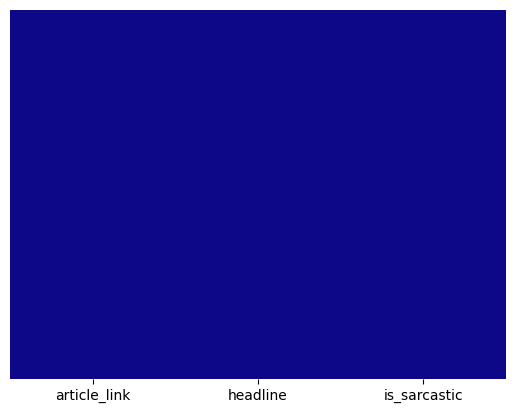

In [5]:
sns.heatmap(data=df.isnull(), cbar=False, yticklabels=False, cmap='plasma')

In [6]:
df.drop(columns=['article_link'], inplace=True)

<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

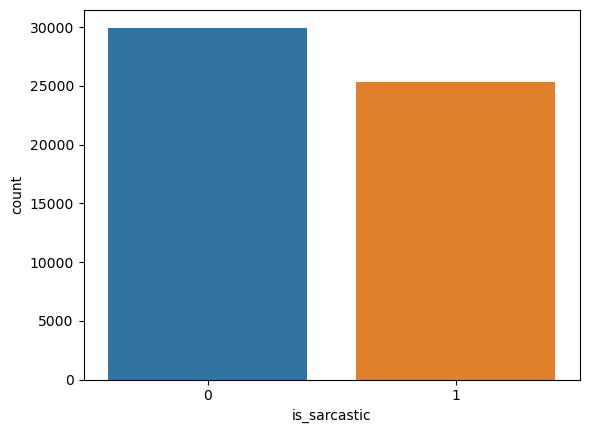

In [7]:
sns.countplot(x='is_sarcastic', data=df)

In [8]:
df['headline']

0        former versace store clerk sues over secret 'b...
1        the 'roseanne' revival catches up to our thorn...
2        mom starting to fear son's web series closest ...
3        boehner just wants wife to listen, not come up...
4        j.k. rowling wishes snape happy birthday in th...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberg-gat...
28618                   dad clarifies this not a food stop
Name: headline, Length: 55328, dtype: object

In [9]:
df['headline'].str.split()

0        [former, versace, store, clerk, sues, over, se...
1        [the, 'roseanne', revival, catches, up, to, ou...
2        [mom, starting, to, fear, son's, web, series, ...
3        [boehner, just, wants, wife, to, listen,, not,...
4        [j.k., rowling, wishes, snape, happy, birthday...
                               ...                        
28614    [jews, to, celebrate, rosh, hashasha, or, some...
28615    [internal, affairs, investigator, disappointed...
28616    [the, most, beautiful, acceptance, speech, thi...
28617    [mars, probe, destroyed, by, orbiting, spielbe...
28618           [dad, clarifies, this, not, a, food, stop]
Name: headline, Length: 55328, dtype: object

In [10]:
df['headline'].str.split().map(lambda x: len(x))

0        12
1        14
2        14
3        13
4        11
         ..
28614     7
28615    13
28616    12
28617     8
28618     7
Name: headline, Length: 55328, dtype: int64

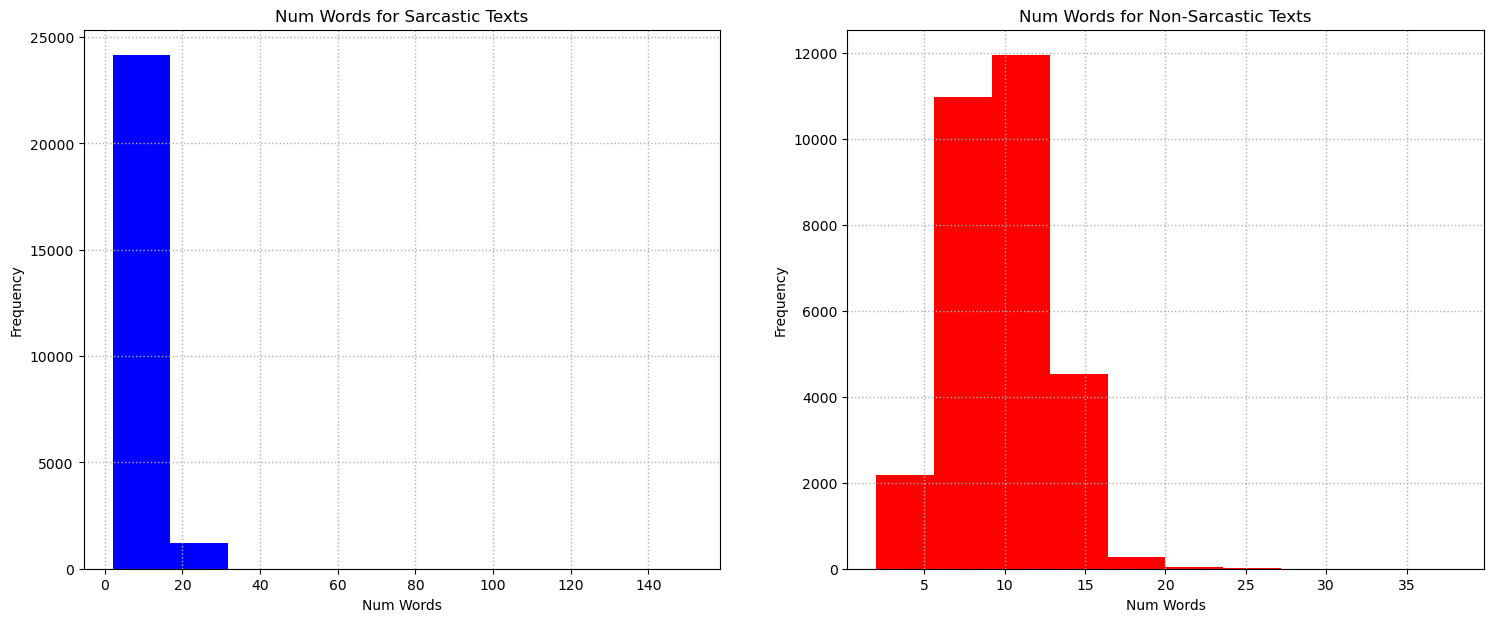

In [11]:
#  Bar plot for no. of words in each headline

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,7))

sar_num_words = df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x)).values
non_sar_num_words = df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x)).values

ax1.hist(sar_num_words, color='blue')
ax1.set_title('Num Words for Sarcastic Texts')
ax1.set_xlabel('Num Words', fontdict={'fontsize':10})
ax1.set_ylabel('Frequency', fontdict={'fontsize':10})
ax1.grid(linestyle='dotted', lw=1)

ax2.hist(non_sar_num_words, color='red')
ax2.set_title('Num Words for Non-Sarcastic Texts')
ax2.set_xlabel('Num Words', fontdict={'fontsize':10})
ax2.set_ylabel('Frequency', fontdict={'fontsize':10})
ax2.grid(linestyle='dotted', lw=1)

plt.subplots_adjust(left=5, right=7)
plt.show()

In [12]:
np.mean(sar_num_words) # mean no. of words in sarcastic texts

10.111917343639089

In [13]:
np.mean(non_sar_num_words) # mean no. of words in non-sarcastic texts

9.815615615615616

In [14]:
len([num for num in sar_num_words if num>20])/len(sar_num_words)*100

# if the max_sequence_length is choosen as 20, then 0.5% of the sarcastic text would be truncated!

0.5008281410205851

In [15]:
len([num for num in non_sar_num_words if num>20])/len(non_sar_num_words)*100

# if the max_sequence_length is choosen as 20, then 0.1% of the non-sarcastic text would be truncated!

0.12012012012012012

In [16]:
max_length = 20

In [17]:
def clean_text(text):
    
    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') 
    text = pattern.sub('', text) # these 2 lines removes any website links if present


    emoji = re.compile("["
                       u"\U0001F600-\U0001FFFF"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)
    text = emoji.sub(r'', text) # these 2 lines removes emojis/flags etc if present

    
    # shortcut expansions
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)

    
    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text) # removes some basic characters if present
    
    return text

In [18]:
def Clean_and_Tokenize(corpus_):
    
    corpus = []

    for line in tqdm(corpus_):
        line = clean_text(line) #initial cleaning
        
        words = nltk.word_tokenize(line)
        
        table = str.maketrans('', '', string.punctuation)
        words = [word.translate(table) for word in words] # these 2 lines remove the puntuation
        
        words = [word for word in words if word.isalpha()] # removing non-alphabetic characters
        
        words = [word for word in words if word not in set(stopwords.words("english"))] # stopwords removal
        
        corpus.append(words)
        
    return corpus

In [19]:
corpus = Clean_and_Tokenize(corpus_=df['headline'].values.tolist())

100%|███████████████████████████████████████████████████████████████████████████| 55328/55328 [01:01<00:00, 903.04it/s]


In [20]:
corpus[:2]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse']]

100%|███████████████████████████████████████████████████████████████████████████| 25358/25358 [00:25<00:00, 996.95it/s]


(-0.5, 499.5, 199.5, -0.5)

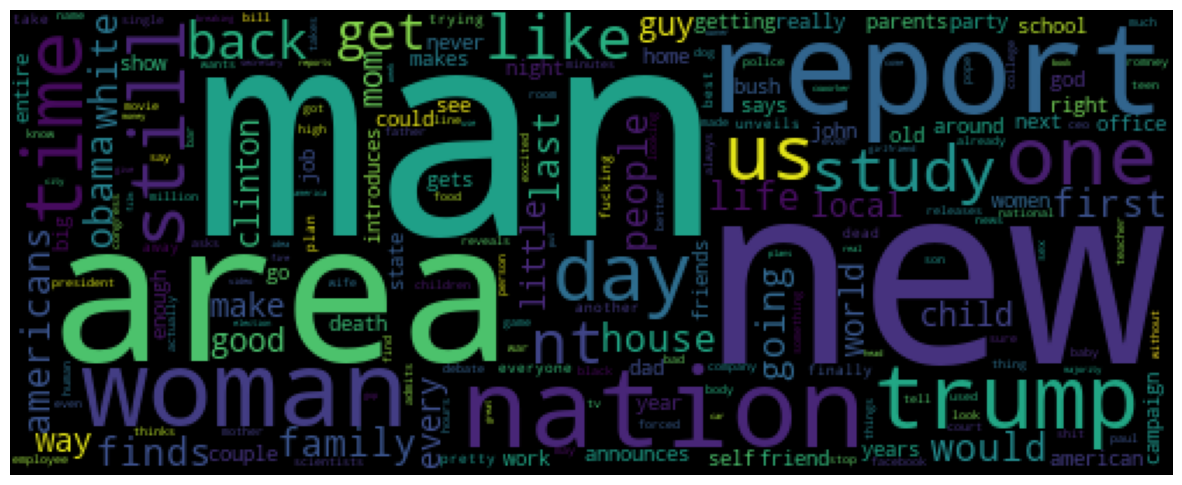

In [21]:
# plotting the wordcloud for sarcastic class!

sar_df = df[df['is_sarcastic']==1] 

sar_df_ = Clean_and_Tokenize(sar_df['headline'].values.tolist()) #cleaning the data

sar_words = [word for line in sar_df_ for word in line] #getting a list of all the words from all the sentences

word_counts = Counter(sar_words)

wordcloud = WordCloud(width=500, height=200).generate_from_frequencies(word_counts)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

100%|███████████████████████████████████████████████████████████████████████████| 29970/29970 [00:30<00:00, 996.88it/s]


(-0.5, 499.5, 199.5, -0.5)

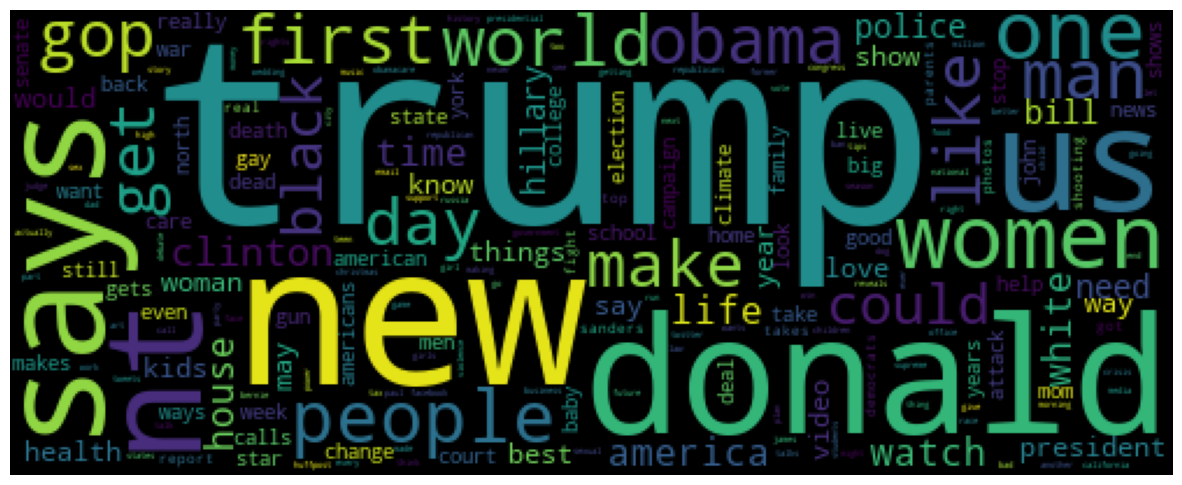

In [22]:
# plotting the wordcloud for non-sarcastic class!

non_sar_df = df[df['is_sarcastic']==0] 

non_sar_df_ = Clean_and_Tokenize(non_sar_df['headline'].values.tolist()) #cleaning the data

non_sar_words = [word for line in non_sar_df_ for word in line] #getting a list of all the words from all the sentences

word_counts = Counter(non_sar_words)

wordcloud = WordCloud(width=500, height=200).generate_from_frequencies(word_counts)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [23]:
# Tokenization

t = Tokenizer()
t.fit_on_texts(corpus)
sequences = t.texts_to_sequences(corpus)

In [24]:
word_index = t.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(t.word_index) + 1
print('vocab size -', vocab_size)

unique tokens -  27860
vocab size - 27861


In [25]:
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y =  df['is_sarcastic'].values

In [26]:
X.shape, y.shape

((55328, 20), (55328,))

In [27]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=77)

In [28]:
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.5, random_state=77)

In [29]:
X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape

((38729, 20), (8299, 20), (8300, 20), (38729,), (8299,), (8300,))

## Model

In [30]:
embedding_index = {}
embedding_dim = 100
glove_dir = "Pre-trained Word Vectors"

In [31]:
f = open(os.path.join(glove_dir, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0] #ek line mei ek word hai and then space word ke embeddings hai space..
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
    
f.close()

In [32]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) #shape is (V,E)

for word, i in word_index.items(): #loop through each word in our present data corpus
    embedding_vector = embedding_index.get(word) #get the embeddings of this word from the pretrained embeddings, if possible.
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector #store the embeddings in the embedding matrix

In [33]:
embedding_matrix.shape, X_train.shape

((27861, 100), (38729, 20))

In [34]:
X_train[0]

array([ 2865, 18671,  2214,  3491,  3110,  3042,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [87]:
model = Sequential(name='PretrainedGloveWithBidirectionalLSTM')

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], 
                   trainable=False))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2)))
model.add(Bidirectional(LSTM(units=32, dropout=0.2)))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))


optimizer_ = tf.keras.optimizers.Adam(lr=0.01)    
model.compile(loss='binary_crossentropy', optimizer=optimizer_, metrics=['accuracy'])

model.summary()

Model: "PretrainedGloveWithBidirectionalLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 100)           2786100   
                                                                 
 bidirectional_18 (Bidirecti  (None, 20, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_19 (Dense)            (

## Training the Model

In [88]:
checkpointer = ModelCheckpoint(filepath = 'saved_checkpoints/PretrainedGloveWithBidirectionalLSTM/checkpoint', 
                               verbose=1, save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=25)


reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=7, verbose=1, min_lr=0.0000001)


start = datetime.now()

trained_model = model.fit(X_train, y_train, batch_size=128, epochs=150, validation_data=(X_validation, y_validation), 
          callbacks=[checkpointer, early_stop, reduce_lr_on_plateau], verbose=1)


duration = datetime.now() - start

print("Training completed in {}".format(duration))

Epoch 1/150
301/303 [============================>.] - ETA: 0s - loss: 0.4690 - accuracy: 0.7776
Epoch 1: val_loss improved from inf to 0.38029, saving model to saved_checkpoints/PretrainedGloveWithBidirectionalLSTM\checkpoint
303/303 [==============================] - 8s 14ms/step - loss: 0.4687 - accuracy: 0.7776 - val_loss: 0.3803 - val_accuracy: 0.8317 - lr: 0.0100
Epoch 2/150
303/303 [==============================] - ETA: 0s - loss: 0.3686 - accuracy: 0.8365
Epoch 2: val_loss improved from 0.38029 to 0.33384, saving model to saved_checkpoints/PretrainedGloveWithBidirectionalLSTM\checkpoint
303/303 [==============================] - 4s 13ms/step - loss: 0.3686 - accuracy: 0.8365 - val_loss: 0.3338 - val_accuracy: 0.8517 - lr: 0.0100
Epoch 3/150
299/303 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8622
Epoch 3: val_loss improved from 0.33384 to 0.31091, saving model to saved_checkpoints/PretrainedGloveWithBidirectionalLSTM\checkpoint
303/303 [============

Epoch 26/150
301/303 [============================>.] - ETA: 0s - loss: 0.1572 - accuracy: 0.9392
Epoch 26: val_loss improved from 0.22597 to 0.22461, saving model to saved_checkpoints/PretrainedGloveWithBidirectionalLSTM\checkpoint
303/303 [==============================] - 3s 11ms/step - loss: 0.1571 - accuracy: 0.9393 - val_loss: 0.2246 - val_accuracy: 0.9223 - lr: 0.0050
Epoch 27/150
300/303 [============================>.] - ETA: 0s - loss: 0.1537 - accuracy: 0.9410
Epoch 27: val_loss improved from 0.22461 to 0.22030, saving model to saved_checkpoints/PretrainedGloveWithBidirectionalLSTM\checkpoint
303/303 [==============================] - 3s 11ms/step - loss: 0.1537 - accuracy: 0.9411 - val_loss: 0.2203 - val_accuracy: 0.9284 - lr: 0.0050
Epoch 28/150
302/303 [============================>.] - ETA: 0s - loss: 0.1493 - accuracy: 0.9419
Epoch 28: val_loss did not improve from 0.22030
303/303 [==============================] - 3s 9ms/step - loss: 0.1494 - accuracy: 0.9419 - val_los

Epoch 52/150
302/303 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9629
Epoch 52: val_loss did not improve from 0.20907
303/303 [==============================] - 3s 10ms/step - loss: 0.0989 - accuracy: 0.9629 - val_loss: 0.2201 - val_accuracy: 0.9459 - lr: 0.0025
Epoch 53/150
297/303 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9633
Epoch 53: val_loss improved from 0.20907 to 0.20333, saving model to saved_checkpoints/PretrainedGloveWithBidirectionalLSTM\checkpoint
303/303 [==============================] - 4s 12ms/step - loss: 0.0975 - accuracy: 0.9632 - val_loss: 0.2033 - val_accuracy: 0.9435 - lr: 0.0025
Epoch 54/150
299/303 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.9622
Epoch 54: val_loss did not improve from 0.20333
303/303 [==============================] - 3s 10ms/step - loss: 0.0992 - accuracy: 0.9623 - val_loss: 0.2263 - val_accuracy: 0.9420 - lr: 0.0025
Epoch 55/150
303/303 [==================

Epoch 78: early stopping
Training completed in 0:04:03.978017


In [89]:
model.load_weights('saved_checkpoints/PretrainedGloveWithBidirectionalLSTM/checkpoint')

## Plotting

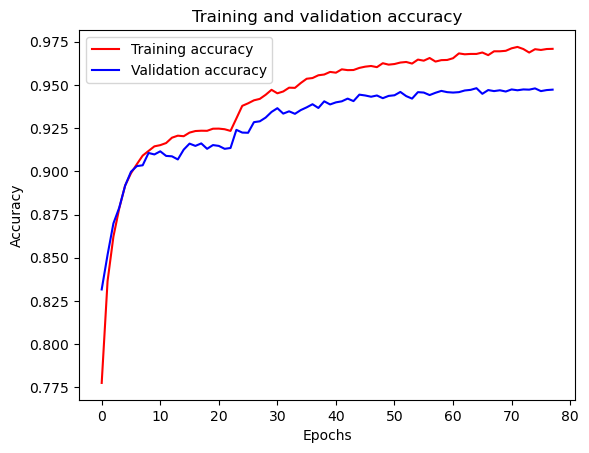

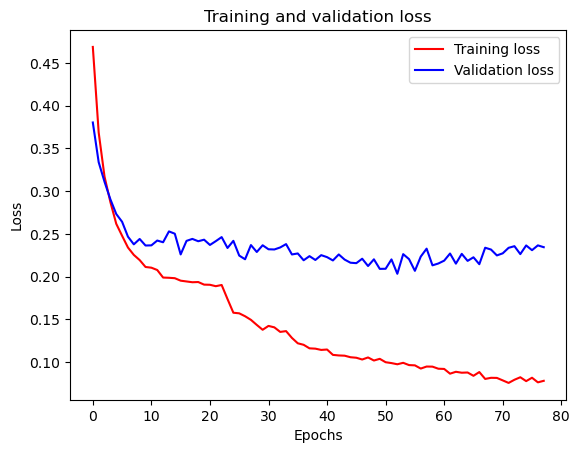

In [90]:
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = list(range(0,78))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation and Testing

In [91]:
val_loss, val_accuracy = model.evaluate(X_validation, y_validation)
print("val_loss = {} and val_accuracy = {}".format(val_loss, val_accuracy))

260/260 [==============================] - 1s 4ms/step - loss: 0.2033 - accuracy: 0.9435
val_loss = 0.203333780169487 and val_accuracy = 0.9434871673583984


In [92]:
test_predictions = model.predict(X_test)

260/260 [==============================] - 2s 4ms/step


In [93]:
test_predictions

array([[4.6556613e-01],
       [8.8222992e-01],
       [1.2981366e-04],
       ...,
       [3.6899166e-04],
       [1.6397661e-06],
       [1.6472926e-02]], dtype=float32)

In [94]:
test_predictions.shape

(8300, 1)

In [95]:
test_predictions[0]

array([0.46556613], dtype=float32)

In [96]:
temp = []
for i in test_predictions:
    if i[0]>=0.5:
        temp.append(1)
    else:
        temp.append(0)

In [97]:
test_predictions = np.array(temp).copy()

In [98]:
test_predictions

array([0, 1, 0, ..., 0, 0, 0])

In [99]:
y_test

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

## Metrics on test set

In [100]:
print(f"Accuracy = {accuracy_score(test_predictions, y_test)}")
print(f"ROC AUC Score = {roc_auc_score(test_predictions, y_test)}")

Accuracy = 0.9480722891566266
ROC AUC Score = 0.9475161502460009


In [101]:
target_classes = ["non-sarcastic", "sarcastic"]

In [102]:
print(classification_report(y_test, test_predictions, target_names=target_classes))

               precision    recall  f1-score   support

non-sarcastic       0.95      0.95      0.95      4539
    sarcastic       0.94      0.94      0.94      3761

     accuracy                           0.95      8300
    macro avg       0.95      0.95      0.95      8300
 weighted avg       0.95      0.95      0.95      8300



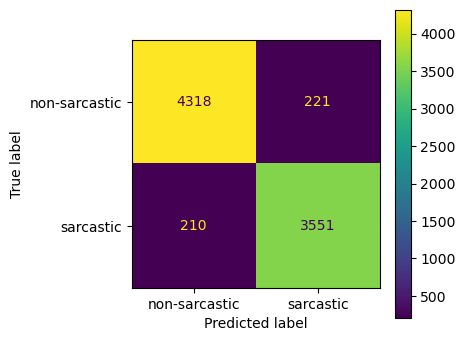

In [103]:
#plotting the confusion matrix for validation data:

fig, ax = plt.subplots(1, figsize=(4,4))
cm_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=target_classes)
cm_plot.plot(ax=ax)

plt.show()

## Testing on self-made data

In [104]:
def test_for_sarcasm(s):
    text = []
    text.append(s)
    cleaned_text = Clean_and_Tokenize(text)
    test_sequence = t.texts_to_sequences(cleaned_text)
    padded_test_sequence = pad_sequences(test_sequence, maxlen=max_length, padding='post')
    prediction = model.predict(padded_test_sequence)
    
    if prediction[0][0]>=0.5: 
        return "It is a sarcastic phrase!" 
    else: 
        return "It is not a sarcastic phrase!"

In [105]:
test_for_sarcasm("You are a extraordinarily poor student. Get a life.")

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]

1/1 [==============================] - 0s 15ms/step


'It is a sarcastic phrase!'